# Data Science for Business - Logit on Micro Mortgages

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, RocCurveDisplay
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

import statsmodels.api as sm
import statsmodels.formula.api as smf


In [2]:
np.random.seed(42)
plt.style.use('fivethirtyeight')

## Case description

In India, there are about 20 million home loan (mortgage) aspirants
working in the informal sector:

- Monthly income between INR 20,000-25,000 (\$ 325-400)
- Typically no formal accounts and documents (e.g., tax returns, income proofs, bank statements)
- Often use services of money lenders with interest rates between 30 and 60% per annum

Providing mortgages to this group of customers requires to quickly and
efficiently assess their creditworthiness. Due to a lack of formal
documents and objective data, most financial institutions perform
interview-based processes to decide about these loan requests:

Strength of the current process:

-   Interview-based field assessment

-   Relaxation of document requirements

Weaknesses of the current process:

-   Costly (total transaction costs as high as 30% of loan volume)

-   Subjective judgments; depends on individual skills and motivations

-   Low reliability across branches and credit officers

-   Risk of corruption and fraud

## Load data

Load training data from CSV file.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/olivermueller/ds4b-2024/refs/heads/main/Session_04/micromortgage.csv')

In [4]:
data.head()

,ID,Decision,Build_Selfcon,Tier,Accommodation_Class,Loan_Type,Gender,Employment_Type,Doc_Proof_Inc,Marital_Status,...,LoanReq,Term,Dwnpay,BankSave,CalcEmi,IIR,IAR,FOIR,LTV,LVR
0,FBD-E2B0-588300,1,Self Contruction,2,Non_Rented,Home_Loan,Female,Salaried,N,Married,...,780000,180,670000,0,12004.230470,34.999797,45.000114,34.999797,80.000000,54.000000
1,GUJ-A79X-831476,0,Self Contruction,1,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,800000,180,470000,0,12312.030270,49.248121,75.533928,49.248121,62.992126,62.992126
2,SHB-947O-759226,1,Self Contruction,3,Rented,Home_Loan,Female,Salaried,N,Married,...,480000,120,120000,300000,8342.290039,41.999144,79.998946,41.999144,78.999992,80.000000
3,SHB-7S3I-679761,1,Self Contruction,3,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,300000,180,95000,0,4617.009766,30.999126,84.996498,30.999126,20.000000,76.000000
4,VAD-BPKZ-551476,0,Self Contruction,2,Non_Rented,Home_Loan,Female,Self_Employed,N,Married,...,1000000,180,375000,0,15390.040040,45.000117,57.999020,45.000117,73.000001,73.000000


## Prepare data

We do some minimal data preparation, that is, drop the `ID` column and turn the `Tier` variable into a string.

In [5]:
data = data.drop(['ID'], axis=1)
data["Tier"] = data["Tier"].apply(lambda x: "T"+str(x))

Next, we perform a standard 80:20 random train-test split.

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

## Exploratory data analysis

### Descriptive summary statistics

Calculate base rate of mortgage approvals.

In [7]:
train["Decision"].mean()

0.8037848605577689

### Explore relationships between response and predictors.

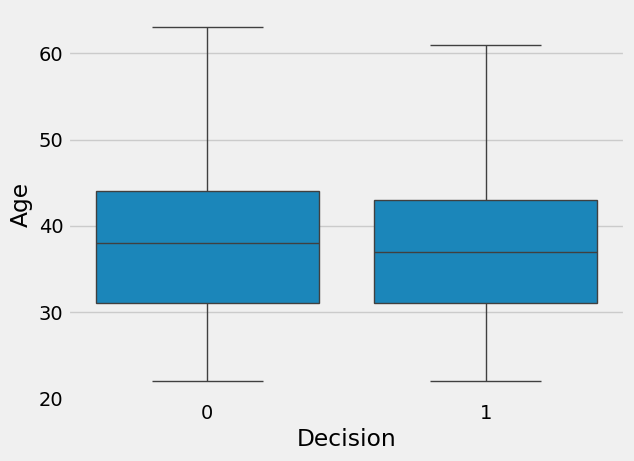

In [8]:
sns.boxplot(data=train, x="Decision", y="Age")
plt.show()

In [9]:
# YOUR CODE HERE

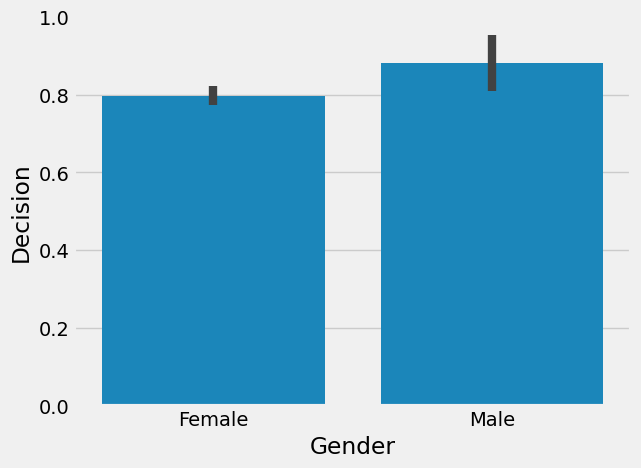

In [10]:
sns.barplot(data=train, x="Gender", y="Decision")
plt.show()

In [11]:
# YOUR CODE HERE

## Fit model

Ok, now we are ready to fit our first logistic regression model. Let's take `Age` and `Gender` as predictors. 

In [18]:
model_logit = smf.logit(formula='Decision ~ Age + Gender + Dwnpay + LoanReq * Term', data=train)
model_logit = model_logit.fit()

Optimization terminated successfully.
         Current function value: 0.480100
         Iterations 6


In [19]:
print(model_logit.summary())

                           Logit Regression Results                           
Dep. Variable:               Decision   No. Observations:                 1004
Model:                          Logit   Df Residuals:                      997
Method:                           MLE   Df Model:                            6
Date:                Mon, 03 Feb 2025   Pseudo R-squ.:                 0.03032
Time:                        10:17:08   Log-Likelihood:                -482.02
converged:                       True   LL-Null:                       -497.09
Covariance Type:            nonrobust   LLR p-value:                 3.694e-05
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1531      0.878      0.174      0.862      -1.569       1.875
Gender[T.Male]     0.7320      0.351      2.084      0.037       0.044       1.420
Age               -0.0008      0.010

## Make predictions

Let's compute predictions, both in the form of probabilities and binary decisions.

In [14]:
pred_proba = model_logit.predict(test)
pred_label = round(pred_proba, 0)

## Evaluate accuracy

We begin by calculating some standard accuracy metrics like Precision, Recall, F1-Score, and Accuracy.

In [15]:
print(classification_report(test["Decision"], pred_label))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        55
           1       0.78      1.00      0.88       197

    accuracy                           0.78       252
   macro avg       0.39      0.50      0.44       252
weighted avg       0.61      0.78      0.69       252



The confusion matrix helps us to diagnose what kind of mistakes the model makes.

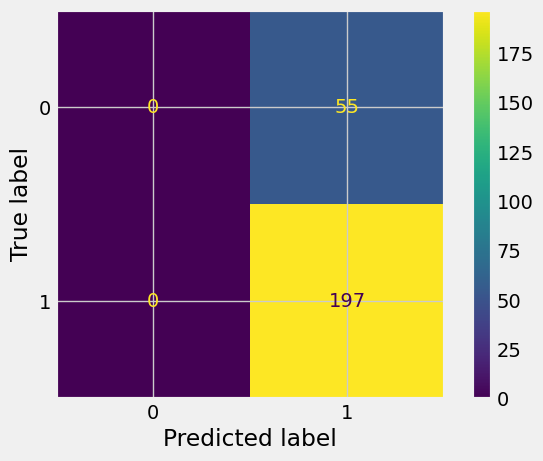

In [16]:
cm = confusion_matrix(test['Decision'], pred_label)
disp = ConfusionMatrixDisplay(confusion_matrix= cm)
disp.plot()
plt.show()

Finally, we compute the AUC, which is a useful metric to characterize the performance of a classifier in one single metric.

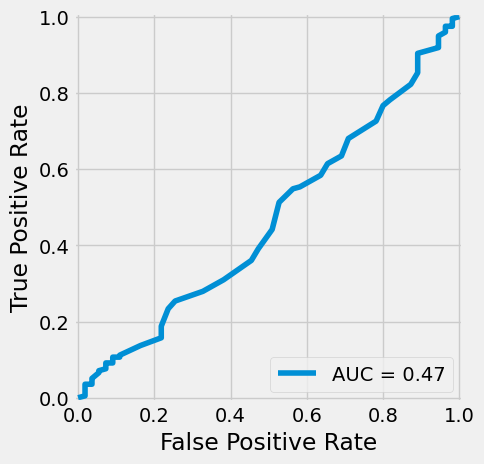

In [17]:
fpr, tpr, thresholds = roc_curve(test["Decision"], pred_proba)
auc_score = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
display.plot()
plt.show()

## Your turn!

Improve the above model by including more predictors!